In [60]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt

## Network Diffusion Model

In [61]:
# Justin's code

class loading_matfiles:
    def __init__(self,datadir_=''):
        if (datadir_==''):
            curdir = os.getcwd()
            subdir = 'raw_data_mouse'
            datadir_ = os.path.join(curdir,subdir)
        self.datadir = datadir_ # Directory to load dependences from
    
    def load_file(self,datafile):
        datafile = os.path.join(self.datadir,datafile)
        datamat = scipy.io.loadmat(datafile)
        return datamat

class run_Nexis:
    def __init__(self,C_,U_,init_vec_,t_vec_,w_dir_=0,volcorrect_=0,use_baseline_=0,region_volumes_=[],degreecorrect_=1,datadir_=''):
        self.C = C_ # Connectivity matrix, nROI x nROI
        self.U = U_ # Matrix or vector of cell type or gene expression, nROI x nTypes
        self.init_vec = init_vec_ # Binary vector indicating seed location OR array of baseline pathology values, nROI x 1
        self.t_vec = t_vec_ # Vector of time points to output model predictions, 1 x nt
        self.volcorrect = volcorrect_ # Binary flag indicating whether to use volume correction - ask ben 
        self.w_dir = w_dir_ # Binary flag indicating whether to use directionality or not 
        self.use_baseline = use_baseline_ # Binary flag indicating whether to use the baseline or binary seed to initialize the model
        self.region_volumes = region_volumes_ # Array of region volumes, nROI x 1 if applicable

        # ADDED BY ROBIN
        self.degreecorrect = degreecorrect_ 
        
        if (datadir_==''):
            curdir = os.getcwd()
            subdir = 'raw_data_mouse'
            datadir_ = os.path.join(curdir,subdir)
        self.datadir = datadir_ # Directory to load dependences from

    def forward_sim(self,A_,t_,x0_):
        y_ = np.zeros([np.shape(A_)[0],len(t_)])
        for i in list(range(len(t_))):
            ti = t_[i]
            y_[:,i] = np.dot(expm(A_*ti),np.squeeze(x0_))
        return y_

    def simulate_ndm(self, parameters):
        """
        Returns a matrix, Y, that is nROI x nt representing the modeled NDM pathology
        given the provided parameters. beta and gamma should be nonnegative scalars;
        s should be bounded between 0 and 1.
        """
        # Define parameters
        beta = parameters[0] # global diffusivity rate (range [0,5])
        if self.use_baseline:
            gamma = 1 # don't rescale baseline pathology
        else:
            gamma = parameters[1] # seed rescale value, if necessary (range [0,10])
        if self.w_dir==0:
            s = 0.5
        else:
            s = parameters[2] # directionality (0 = anterograde, 1 = retrograde)  
            
        # Define starting pathology x0
        x0 = gamma * self.init_vec # Calculate initial vector scaled by gamma
        
        # Define Laplacian matrix L
        C_dir = (1-s) * np.transpose(self.C) + s * self.C
        coldegree = np.sum(C_dir,axis=0)
        L_raw = np.diag(coldegree) - C_dir

        # Initialize L with L_raw as default (ADDED BY ROBIN)
        L = L_raw

        # Apply volume correction if applicable
        if self.volcorrect:
            voxels_2hem = self.region_volumes

            # ROBIN'S EDIT
            inv_voxels_2hem = np.diag(np.squeeze(voxels_2hem).astype(float) ** (-1))
            
            #ORIGINAL
            #inv_voxels_2hem = np.diag(np.squeeze(voxels_2hem) ** (-1))
            
            L = np.mean(voxels_2hem) * np.dot(inv_voxels_2hem,L)
    
        # ADDED BY ROBIN: normalize by degree if applicable
        if self.degreecorrect:

            inv_degree = np.diag(np.squeeze(coldegree).astype(float) ** (-1))
            
            L = np.mean(coldegree) * np.dot(inv_degree,L)
            
        # Define system dydt = Ax
        A = -beta * L

        # Solve analytically
        y = self.forward_sim(A,self.t_vec,x0)
        return y

class data_conversion: # relevant for mouse specifically, not yet coded
    def __init__(self,datadir=''):
        pass

    def CCF_to_Data(self):
        pass

    def Data_to_CCF(self):
        pass

        # def network_transfer(params,w):
        #     tau_e = params[0]
        #     tau_i = params[1]
        #     gii = params[2]
        #     gei = params[3]
        #     # pw_scale = params[4]
        #     pw_scale = 1
        #     gee = 1


        #     # Cortical model
        #     Fe = np.divide(1 / tau_e ** 2, (1j * w + 1 / tau_e) ** 2)
        #     Fi = np.divide(1 / tau_i ** 2, (1j * w + 1 / tau_i) ** 2)

        #     Hed = (1 + (Fe * Fi * gei)/(tau_e * (1j * w + Fi * gii/tau_i)))/(1j * w + Fe * gee/tau_e + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fi * gii / tau_i)))
            
        #     Hid = (1 - (Fe * Fi * gei)/(tau_i * (1j * w + Fe * gee/tau_e)))/(1j * w + Fi * gii/tau_i + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fe * gee / tau_e)))

        #     Htotal = Hed + Hid
            
        #     return pw_scale*Htotal
        

        # freq_mdl = []
        # for freq in self._fvec:
        #     _w = 2 * np.pi * freq
        #     freq_model = network_transfer(parameters, _w)
        #     freq_mdl.append(freq_model)

        # freq_mdl = np.transpose(np.asarray(freq_mdl))
        
        # # freq_out = functions.mag2db(np.abs(freq_mdl))
        
        # return np.abs(freq_mdl)



## Running the model

In [62]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# List of striatal regions to exclude from further analysis due to errors in tau-PET imaging (CAN EDIT THIS!!)
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Define total number of subcortical regions and cortical regions per hemisphere
total_sub = 9 - len(regions_to_exclude)/2
total_cor = 34

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max


In [64]:
# Define the number of regions included in analysis 
nROI = 86 - len(regions_to_exclude)


In [149]:
# Initial vector

# SET INITIAL VECTOR METHOD ('baseline' or 'binary')
init_vec_method = 'baseline' 

# OPTION 1: Use baseline data from EBM tau time series
if init_vec_method == 'baseline':

    init_con = pandas.read_csv('Regional tau time series -with lobar volumes (without duplicates).csv')

    # Housekeeping
    init_con = init_con.drop('Unnamed: 0',axis=1)

    # Reorder regions to match region order of connectivity matrix
    new_order = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
    init_con_reordered = init_con.iloc[:, new_order]

    # Delete striatal regions 
    columns_to_delete = init_con_reordered.columns[excluded_indices]
    init_con_excluded = init_con_reordered.drop(columns_to_delete, axis = 1)

    # Take the first row (time point 0) as initial vector
    init_vec = init_con_excluded.iloc[0].values

    # Set use_baseline NEXIS input to 1 to indicate use of baseline data as initial vector  
    use_baseline_ = 1 

#OPTION 2: Binary vector indicating seeding location 
if init_vec_method == 'binary':

    # lh-entorhinal: 14 if excluding striatal regions (22 if not)
    # rh-entorhinal: 48 if excluding striatal regions (56 if not)

    # Create a 1D array of zeros with length nROI
    array_length = nROI
    init_vec = np.zeros(array_length)

    # Set entries for seeding location to 1 
    init_vec[14] = 1 
    init_vec[48] = 1

    # Set use_baseline NEXIS input to 0 to indicate use of binary initial vector 
    use_baseline_ = 0 


In [66]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Reorder to match that of connectivity matrix
new_order = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)


In [150]:
# Define inputs to NDM

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.array([])  # Don't use this set to any value (nROI x nTypes)
init_vec_ = init_vec # Initial tau vector with 0 at each region and 1 at seeding location (nROI x 1)
t_vec_ = np.linspace(0, 10, 100)  # Time vector (include 100 time points) (1 x nt)
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # regional volumes for normalization (nROI x 1)
degreecorrect_ = 0 # Binary flag indicating whether to normalize by degree (for Ashish, normally set this to 0)
datadir_ = "../NDM output/NDM_output.csv"  # Data directory for output


In [151]:
# Running NDM

# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, degreecorrect_=degreecorrect_, datadir_=datadir_)

# Parameters for simulate_ndm method
parameters = [1, 1, 0.5]  # [beta, gamma, s] # MANUALLY ADJUST BETA HERE

# beta = diffusivity constant/ the rate of diffusivity (0-5)
# gamma = seed rescale value that fits NDM pathology to the same scale as seed value
# s = directionaility constant (if no directionaility, set to 0.5)

# Call the simulate_ndm method with the parameters
Y = nexis_model.simulate_ndm(parameters)

# Print resulting matrix (nROI x # of time points)
print(Y)

[[0.99075314 0.99158673 0.99233093 ... 1.01454483 1.01471337 1.01488133]
 [1.19896644 1.18466968 1.1717255  ... 1.06637677 1.06635585 1.06633483]
 [1.20833085 1.19902379 1.19062392 ... 1.07007336 1.06999015 1.06990909]
 ...
 [1.08817778 1.09221594 1.09547926 ... 1.0709489  1.07087625 1.07080527]
 [0.97743564 0.99866335 1.01495507 ... 1.07069352 1.07064428 1.07059556]
 [1.08430173 1.08121948 1.07898377 ... 1.07025968 1.07022238 1.07018524]]


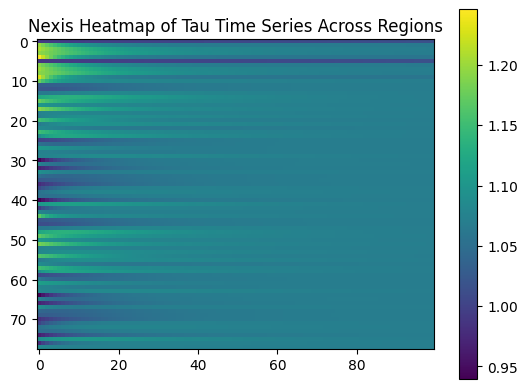

In [152]:
# Generate heat map of NEXIS output 

if init_vec_method == 'baseline':
    plt.imshow(Y, cmap='viridis', interpolation='none')
    plt.colorbar()  # Add a color bar to map colors to values
    plt.title('Nexis Heatmap of Tau Time Series Across Regions')
    plt.show()

if init_vec_method == 'binary': 
# Exclude binary seeding location for binary initial vector so it does not drown out the signal in other regions (EDIT SEEDING LOCATION HERE)
    Y_modified = np.delete(Y, [14,48], axis=0) # NEED TO CHANGE for different seeding regions or different list of total regions
    plt.imshow(Y_modified, cmap='viridis', interpolation='none')
    plt.colorbar()  # Add a color bar to map colors to values
    plt.title('Nexis Heatmap of Tau Time Series Across Regions')
    plt.show()

## Compare NDM output to EBM time series

In [141]:
# Load tau time series from EBM (E(t)) to compare with NDM output (Y)

EBM_data = pandas.read_csv('Regional tau time series -with lobar volumes (without duplicates).csv')

# Housekeeping
EBM_data = EBM_data.drop('Unnamed: 0',axis=1)

# Convert to an nROI x 100 array and transpose
EBM_data_array = EBM_data.values
EBM_data_transposed = EBM_data_array.T

# Reorder regions to match region order in NDM output
new_order = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
EBM_data_reordered = EBM_data_transposed[new_order, :]

# Delete striatal regions 
EBM_data_excluded = np.delete(EBM_data_reordered, excluded_indices,axis = 0)


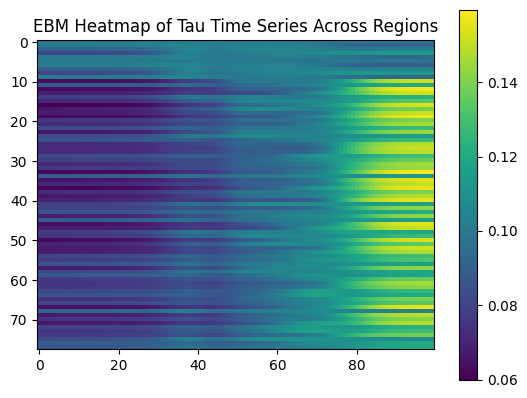

In [105]:
# Generate heat map of EBM data
plt.imshow(EBM_data_excluded, cmap='viridis', interpolation='none')
plt.colorbar()  # Add a color bar to map colors to values
plt.title('EBM Heatmap of Tau Time Series Across Regions')
plt.show()


In [153]:
# Calculate the correlation coefficients R(t) for each time point i between EBM output E(t) and Y x(t)

# Create R(t) vector list
R_t = []

# Find R for each time point i
for i in range(0,100):
    corr_matrix = np.corrcoef(EBM_data_excluded[:,i], Y[:,i])

    # The correlation coefficient between EBM_data and Y for the ith time point
    corr_coefficient = corr_matrix[0, 1]

    R_t.append(corr_coefficient)

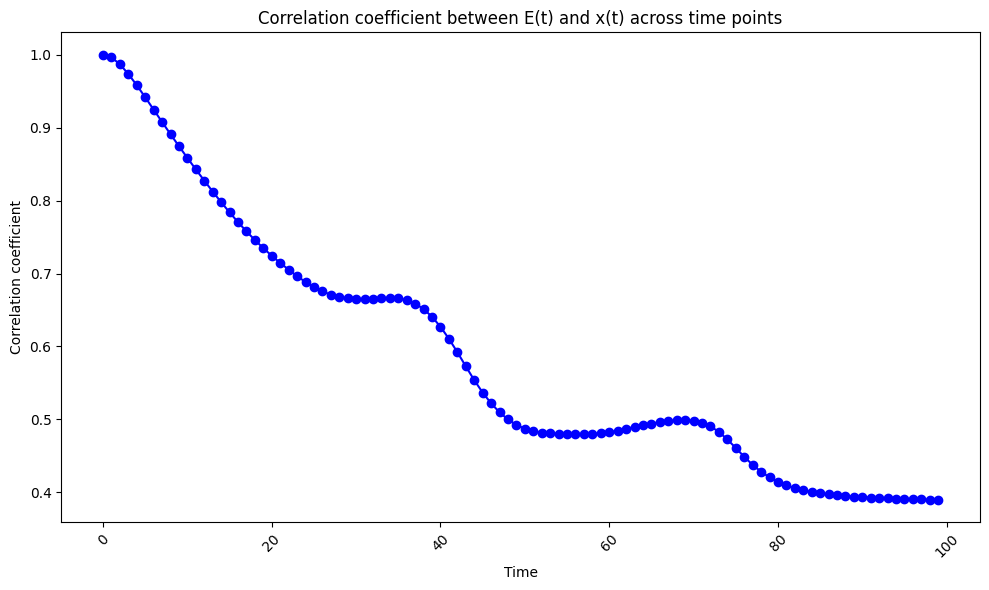

R-max:1.0
t-max:0
R-average: 0.5870176336993367


In [154]:
# Plot R(t)
time_points = np.linspace(0, 99, 100)

plt.figure(figsize=(10, 6))
plt.plot(time_points, R_t, marker='o', linestyle='-', color='b')  
plt.title('Correlation coefficient between E(t) and x(t) across time points') 
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Correlation coefficient')  
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
plt.tight_layout()  # Optional: adjusts subplot params for the figure to fit into the figure area

# Show the plot
plt.show()

# Calculate maximum R value and corresponding t
max_t = np.argmax(R_t)
max_R = R_t[max_t]

# Calculate the average R value across all time points
R_average = sum(R_t) / 100

print('R-max:' + str(max_R))
print('t-max:' + str(max_t))
print('R-average: ' + str(R_average))


In [155]:
# Calculate MSE between E(t) and Y

# Noramlize Y and BM data by L2 norm (MSE does not perform well with different overall scales)

# Function to normalize a matrix by L2 norm of each row
def normalize_by_l2_norm(matrix):
    l2_norms = np.linalg.norm(matrix, axis=1, keepdims=True)  # Calculate L2 norm for each row
    normalized_matrix = matrix / l2_norms  # Normalize each row by its L2 norm
    return normalized_matrix

# Normalize 
normalized_Y = normalize_by_l2_norm(Y)
normalized_EBM_data_excluded = normalize_by_l2_norm(EBM_data_excluded)

# Define MSE function
def mse_matrix(matrix1,matrix2):
    # Ensure the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same dimensions")
    return np.mean((matrix1 - matrix2) ** 2) # Calculate MSE

mse = mse_matrix(normalized_EBM_data_excluded, normalized_Y)
print('Mean squared error: ' + str(mse))

Mean squared error: 0.00048714575260436145


## Checking relative scale of EBM and Y

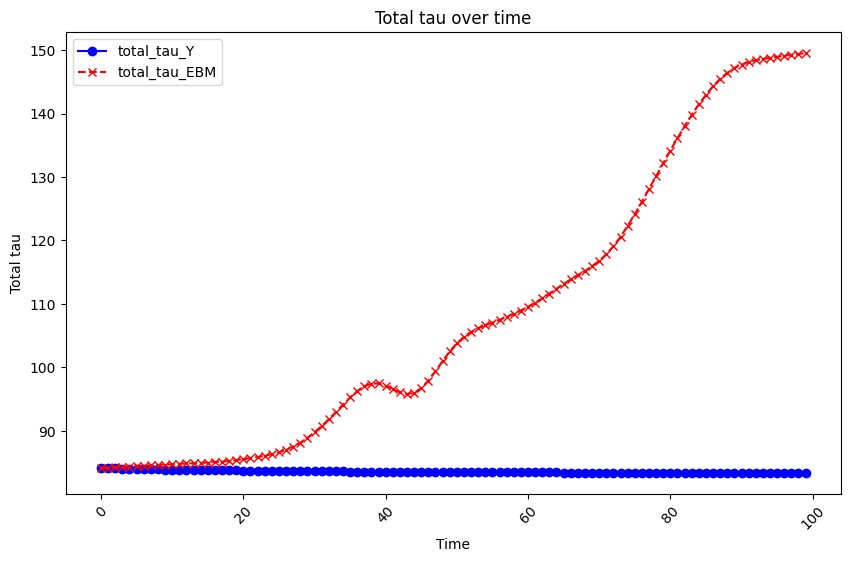

In [156]:
# Plot total tau over time for both EBM output and Y to compare the overall scales

# Create vector for total tau at each time point for both Y and E(t)
total_tau_Y = np.sum(Y, axis=0)
total_tau_EBM = np.sum(EBM_data_excluded, axis=0)

time_points = np.linspace(0, 99, 100)

plt.figure(figsize=(10, 6))

# Plot total_tau_Y
plt.plot(time_points, total_tau_Y, marker='o', linestyle='-', color='b', label='total_tau_Y')  

# Plot total_tau_EBM on the same graph
plt.plot(time_points, total_tau_EBM, marker='x', linestyle='--', color='r', label='total_tau_EBM')

plt.title('Total tau over time') 
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Total tau')  # Label the y-axis
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
plt.legend()  # Add a legend to distinguish the two lines

# Show the plot
plt.show()

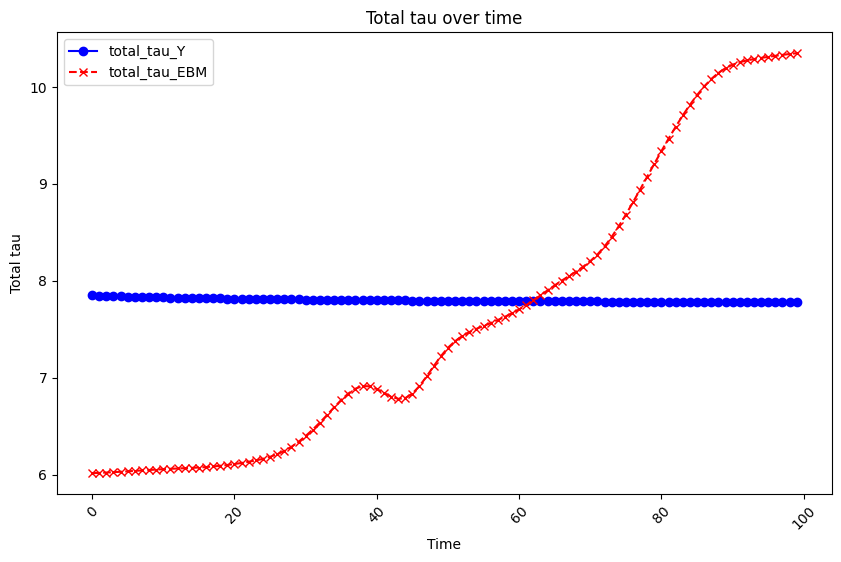

In [157]:
# Check results of normalization

# Create vector for total tau at each time point for both Y and E(t)
total_tau_Y = np.sum(normalized_Y, axis=0)
total_tau_EBM = np.sum(normalized_EBM_data_excluded, axis=0)

time_points = np.linspace(0, 99, 100)

plt.figure(figsize=(10, 6))

# Plot total_tau_Y
plt.plot(time_points, total_tau_Y, marker='o', linestyle='-', color='b', label='total_tau_Y')  

# Plot total_tau_EBM on the same graph
plt.plot(time_points, total_tau_EBM, marker='x', linestyle='--', color='r', label='total_tau_EBM')

plt.title('Total tau over time') 
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Total tau')  # Label the y-axis
plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
plt.legend()  # Add a legend to distinguish the two lines

# Show the plot
plt.show()

## Parameter Optimization

In [158]:
# METHOD 1
# Loop through beta values to find beta with highest R-max

# Define beta values to loop through
beta_values = np.linspace(0,25,100) # min, max, number of values 

# Set variable for maximum R value and its corresponding beta value
overall_max_R = 0
max_beta = 0

# Create a data frame for R(t) vectors across beta values (columns = beta values, rows = time points)
R_beta_df = pandas.DataFrame()

for beta in beta_values:

    # Initialize run_Nexis class 
    nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, datadir_=datadir_)

    # Parameters for simulate_ndm method
    parameters = [beta, 1, 0.5]  # [beta, gamma, s]

    # Call the simulate_ndm method with the parameters
    Y = nexis_model.simulate_ndm(parameters)

    
    # Calculate the correlation coefficients R(t) for each time point i between EBM output E(t) and Y x(t)

    # Create R(t) vector list
    R_t = []

    # Find R for each time point i
    for i in range(0,100):
        corr_matrix = np.corrcoef(EBM_data_excluded[:, i], Y[:,i])

        # The correlation coefficient between EBM_data and Y for the ith time point
        corr_coefficient = corr_matrix[0, 1]

        R_t.append(corr_coefficient)

     # Add R(t) to the data frame 
    R_beta_df[beta] = R_t

    # Calculate maximum R value
    max_t = np.argmax(R_t)
    max_R = R_t[max_t]

    # If max R for a beta value is greater than any other beta
    if max_R > overall_max_R:
        max_beta = beta # Set max_beta to be current beta value
        overall_max_R = max_R # Set max R to be overall_max_R
        overall_max_t = max_t # Set max t to be overall_max_t

print('Optimized beta:' + str(max_beta))
print('R-max:' + str(overall_max_R))
print('T-max:' + str(overall_max_t))
    

KeyboardInterrupt: 

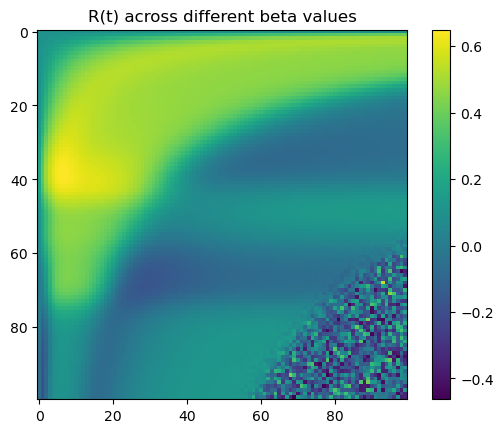

In [98]:
# Generate heat map of R(t) across beta values 

plt.imshow(R_beta_df, cmap='viridis', interpolation='none')
plt.colorbar()  # Add a color bar to map colors to values
plt.title('R(t) across different beta values')

plt.show()


In [148]:
# METHOD 2: Optimize beta (and gamma if using binary seeding) based on minimizing MSE between matrices

from scipy.optimize import minimize

# Define MSE function
def mse_matrix(matrix1,matrix2):
    if matrix1.shape != matrix2.shape:
        raise ValueError("Matrices must have the same dimensions")
    return np.mean((matrix1 - matrix2) ** 2) # Calculate MSE

# Define a function that runs NDM and calculates the MSE of Y and E(t) based on beta (and gamma if using binary initial vector)
def EBM_Nexis_MSE(params):
    
    param1, param2 = params # param1 = beta, param2 = gamma

   # Initialize run_Nexis class 
    nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, degreecorrect_=degreecorrect_, datadir_=datadir_)

    # Parameters for simulate_nexis method
    parameters = [param1, param2, 0.5]  # [beta, gamma, s] 

    # Call the simulate_nexis method with the parameters
    Y = nexis_model.simulate_ndm(parameters)

    # Normalize Y
    normalized_Y = normalize_by_l2_norm(Y)

    error = mse_matrix(normalized_EBM_data_excluded, normalized_Y)
    
    return error

# Initial guesses for parameters (beta, gamma) # ADJUST THESE
init_guess = np.array([1, 1])

# Bounds for each parameter [(min beta, max beta), (min gamma, max gamma)] # ADJUST THESE
bounds = [(0, 5), (0,10)]

# Perform the optimization
result = minimize(EBM_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B', 
                  options={'ftol': 1e-4, 'gtol': 1e-3})

# Check the results
if result.success:
    optimized_params = result.x
    print(f"Optimization successful. Optimized parameters (beta, gamma): {optimized_params}")
else:
    print("Optimization failed.", result.message)

Optimization successful. Optimized parameters (beta, gamma): [1. 1.]


## Loop through different seeding locations

In [105]:
# Need to run cells in "Run model" section first
# Loops through beta values for each seeding location (loop within a loop)

# Create list of bilateral seeding regions (subcortical, cortical) 
regions_list = ['Cerebellum-Cortex', 'Thalamus-Proper', 'Caudate','Putamen','Pallidum','Hippocampus', 'Amygdala', 'Accumbens-area','VentralDC','ctx-bankssts', 'ctx-caudalanteriorcingulate', 'ctx-caudalmiddlefrontal', 'ctx-cuneus', 'ctx-entorhinal', 'ctx-fusiform', 'ctx-inferiorparietal', 'ctx-inferiortemporal', 'ctx-isthmuscingulate', 'ctx-lateraloccipital', 'ctx-lateralorbitofrontal', 'ctx-lingual', 'ctx-medialorbitofrontal', 'ctx-middletemporal', 'ctx-parahippocampal', 'ctx-paracentral', 'ctx-parsopercularis', 'ctx-parsorbitalis', 'ctx-parstriangularis', 'ctx-pericalcarine', 'ctx-postcentral', 'ctx-posteriorcingulate', 'ctx-precentral', 'ctx-precuneus', 'ctx-rostralanteriorcingulate', 'ctx-rostralmiddlefrontal', 'ctx-superiorfrontal', 'ctx-superiorparietal', 'ctx-superiortemporal', 'ctx-supramarginal', 'ctx-frontalpole', 'ctx-temporalpole', 'ctx-transversetemporal', 'ctx-insula']

# Delete excluded regions from the regions list

regions_to_delete = ['Pallidum', 'Accumbens-area', 'Putamen', 'Caudate'] # EDIT THIS depending on which regions are excluded
regions_list = [item for item in regions_list if item not in regions_to_delete]

# Create a table with overall R-max, T-max, and optimized beta for each seeding region
seeding_results = pandas.DataFrame(columns = ['R-max', 'T-max', 'Optimized beta'])


In [106]:
# Loop through subcortical regions 
for i in range(0,int(total_sub)): # Loop through the number of subcortical regions 

    # Create initial vector array (every entry is 0 except bilateral seeding locations each set to 1)

    # Create a 1D array of zeros with length nROI
    array_length = nROI
    init_vec = np.zeros(array_length)
    
    # Set left and right seeding location indices to 1
    init_vec[i] = 1  
    init_vec[i + int(total_sub)] = 1 # Add the total number of subcortical regions to i 

    # Set initial vector parameter to the new init_vec for seeding location i
    init_vec_ = init_vec
    
    # Loop through beta values to find beta with highest R-max

    # Define beta values to loop through
    beta_values = np.linspace(0,25,100) # min, max, number of values 

    # Set variable for optimized beta value and its corresponding maximum R and t value
    max_beta = 0
    overall_max_R = 0
    overall_max_t = 0

    for beta in beta_values:

        # Initialize run_Nexis class 
        nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, degreecorrect_=degreecorrect_, datadir_=datadir_)

        # Parameters for simulate_ndm method
        parameters = [beta, 1, 0.5]  # [beta, gamma, s]

        # Call the simulate_ndm method with the parameters
        Y = nexis_model.simulate_ndm(parameters)

        # Calculate the correlation coefficients R(t) for each time point i between EBM output E(t) and Y x(t)

        # Create R(t) vector list
        R_t = []

        # Find R for each time point i
        for k in range(0,100):
            corr_matrix = np.corrcoef(EBM_data_excluded[:,k], Y[:,k])

            # The correlation coefficient between EBM_data and Y for the ith time point
            corr_coefficient = corr_matrix[0, 1]

            R_t.append(corr_coefficient)

        # Add R(t) to the data frame 
        R_beta_df[beta] = R_t

        # Calculate maximum R value
        max_t = np.argmax(R_t)
        max_R = R_t[max_t]

        # If max R for a beta value is greater than any other beta
        if max_R > overall_max_R:
            max_beta = beta # Set max_beta to be current beta value
            overall_max_R = max_R # Set max R to be overall_max_R
            overall_max_t = max_t # Set max t to be overall_max_t
            
    # Add a new row to seeding_results for the seeding location i
    seeding_results.loc[str(regions_list[i])] = [overall_max_R, overall_max_t, max_beta]


In [107]:
# Loop through cortical regions 
for i in range(int(2 * total_sub),int(2 * total_sub + total_cor)): # Loop through the number of cortical regions 

    # Create initial vector array (every entry is 0 except bilateral seeding locations each set to 1)

    # Create a 1D array of zeros with length nROI
    array_length = nROI
    init_vec = np.zeros(array_length)
    
    # Set left and right seeding location indices to 1
    init_vec[i] = 1  
    init_vec[i + int(total_cor)] = 1 # Add the total number of cortical regions to i 

    # Set initial vector parameter to the new init_vec for seeding location i
    init_vec_ = init_vec
    
    
    # Loop through beta values to find beta with highest R-max

    # Define beta values to loop through
    beta_values = np.linspace(0,25,100) # min, max, number of values 

    # Set variable for optimized beta value and its corresponding maximum R and t value
    max_beta = 0
    overall_max_R = 0
    overall_max_t = 0

    for beta in beta_values:

        # Initialize run_Nexis class 
        nexis_model = run_Nexis(C_=C_, U_=U_, init_vec_=init_vec_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_, use_baseline_=use_baseline_,
                        region_volumes_=region_volumes_, degreecorrect_=degreecorrect_, datadir_=datadir_)

        # Parameters for simulate_ndm method
        parameters = [beta, 1, 0.5]  # [beta, gamma, s]

        # Call the simulate_ndm method with the parameters
        Y = nexis_model.simulate_ndm(parameters)

        # Calculate the correlation coefficients R(t) for each time point i between EBM output E(t) and Y x(t)

        # Create R(t) vector list
        R_t = []

        # Find R for each time point i
        for k in range(0,100):
            corr_matrix = np.corrcoef(EBM_data_excluded[:, k], Y[:,k])

            # The correlation coefficient between EBM_data and Y for the ith time point
            corr_coefficient = corr_matrix[0, 1]

            R_t.append(corr_coefficient)

        # Add R(t) to the data frame 
        R_beta_df[beta] = R_t

        # Calculate maximum R value
        max_t = np.argmax(R_t)
        max_R = R_t[max_t]

        # If max R for a beta value is greater than any other beta
        if max_R > overall_max_R:
            max_beta = beta # Set max_beta to be current beta value
            overall_max_R = max_R # Set max R to be overall_max_R
            overall_max_t = max_t # Set max t to be overall_max_t

    # Add a new row to seeding_results for the seeding location i
    seeding_results.loc[str(regions_list[i-int(total_sub)])] = [overall_max_R, overall_max_t, max_beta] # Subtract from i the number of subcortical regions (MAY NEED TO CHANGE) 


In [26]:
print(seeding_results)

                                 R-max  T-max  Optimized beta
Cerebellum-Cortex             0.332928   43.0       19.191919
Thalamus-Proper               0.366899   41.0       25.000000
Hippocampus                   0.580320   38.0        3.030303
Amygdala                      0.555258   36.0        7.828283
VentralDC                     0.368383    1.0        3.787879
ctx-bankssts                  0.556850   65.0        0.505051
ctx-caudalanteriorcingulate   0.197167   99.0        2.525253
ctx-caudalmiddlefrontal       0.239685   99.0        0.757576
ctx-cuneus                    0.481754   69.0        1.010101
ctx-entorhinal                0.577893   37.0        5.303030
ctx-fusiform                  0.564372   43.0        0.505051
ctx-inferiorparietal          0.693125   66.0        0.252525
ctx-inferiortemporal          0.709793   60.0        0.252525
ctx-isthmuscingulate          0.367236   35.0       25.000000
ctx-lateraloccipital          0.582093   69.0        0.252525
ctx-late

In [108]:
# Save seeding results to csv
seeding_results.to_csv('Seeding Results NDM and EBM Correlation - volume normalization.csv')

In [115]:
# Sort regions by R-max
seeding_results_sorted = seeding_results.sort_values(by='R-max', ascending=True)

,Unnamed: 0,R-max,T-max,Optimized beta
0,Cerebellum-Cortex,0.000000,0.0,0.000000
38,ctx-insula,0.422101,73.0,25.000000
22,ctx-parsorbitalis,0.422101,73.0,24.242424
20,ctx-paracentral,0.422101,73.0,24.242424
35,ctx-frontalpole,0.422101,73.0,24.242424
6,ctx-caudalanteriorcingulate,0.422101,73.0,24.242424
15,ctx-lateralorbitofrontal,0.422101,73.0,24.242424
26,ctx-posteriorcingulate,0.422101,73.0,24.242424
1,Thalamus-Proper,0.422101,73.0,24.242424
30,ctx-rostralmiddlefrontal,0.422101,73.0,6.313131


In [116]:
# Save to csv 
seeding_results_sorted.to_csv('Seeding Results NDM and EBM Correlation - volume normalization -sorted.csv')